https://www.pymc-labs.com/blog-posts/markov-process/

In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [2]:
#president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls_historical.csv'
#df = pd.read_csv(president_polls_url)
#df.to_csv("../Data/raw/president_polls_historical.csv")

In [3]:
df = pd.read_csv("../Data/raw/president_polls_historical.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_46012/3267419697.py:1: DtypeWarning: Columns (17,18,27,29,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/raw/president_polls_historical.csv")


In [4]:
df['date'] = pd.to_datetime(df['end_date'])
df['week'] = (df['date'] - pd.Timestamp('2020-11-03')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2020-11-03')).dt.days

df = df[df['date'] >= '2019-11-03'] #Only polls since one year before election
df = df[df['date'] <= '2020-07-03'] #Only polls since one year before election

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_46012/2590563461.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['end_date'])


In [5]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [6]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'

df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(df_2way[['DEM', 'GOP']].sum(axis=1), axis=0)

In [7]:
df = pd.concat([df_2way])
df.dropna()
df['obs_id'] = range(len(df))
df = df.set_index('date')

# Apply the function to create 'type_id' column
df['type_bt'] = (df['type'] == '2way').astype(int)

Two way Biden vs Trump, Biden leads by 5.5%

In [8]:
df_2way[['DEM', 'GOP']].describe()

,DEM,GOP
count,981.000000,981.000000
mean,0.526986,0.473014
std,0.056539,0.056539
min,0.215317,0.099058
25%,0.510638,0.452381
50%,0.528736,0.471264
75%,0.547619,0.489362
max,0.900942,0.784683


In [9]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2019, and increased exponentially through election day.

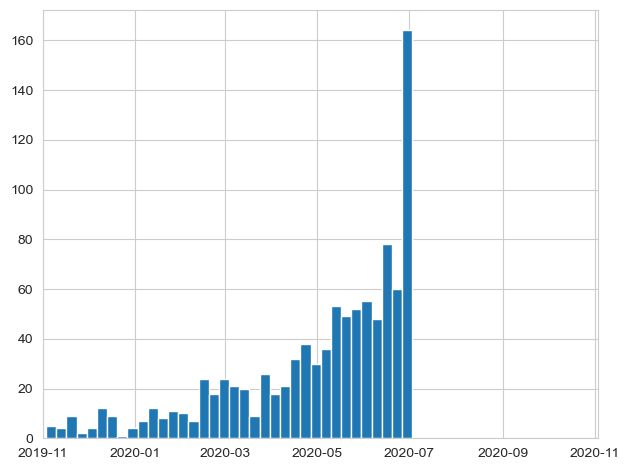

In [10]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2019, 11, 1), dt.datetime(2020, 11, 3))

plt.tight_layout()
plt.show()

In [11]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Probability Panel,IVR/Text,IVR/Online Panel,Text-to-Web/Online Ad,Live Phone/Online Panel,Online Panel/Online Ad,Live Phone/Text-to-Web,IVR/Live Phone
pollster,,,,,,,,,,,
All,981,557,188,49,39,36,28,18,16,9,7
Morning Consult,163,163,0,0,0,0,0,0,0,0,0
SurveyMonkey,151,151,0,0,0,0,0,0,0,0,0
Øptimus,52,46,0,0,0,0,0,0,0,6,0
YouGov,48,48,0,0,0,0,0,0,0,0,0
Ipsos,44,0,0,44,0,0,0,0,0,0,0
PPP,35,0,0,0,34,0,0,0,0,0,0
Change Research,30,0,0,0,0,0,28,0,0,0,0
Beacon/Shaw,21,0,21,0,0,0,0,0,0,0,0


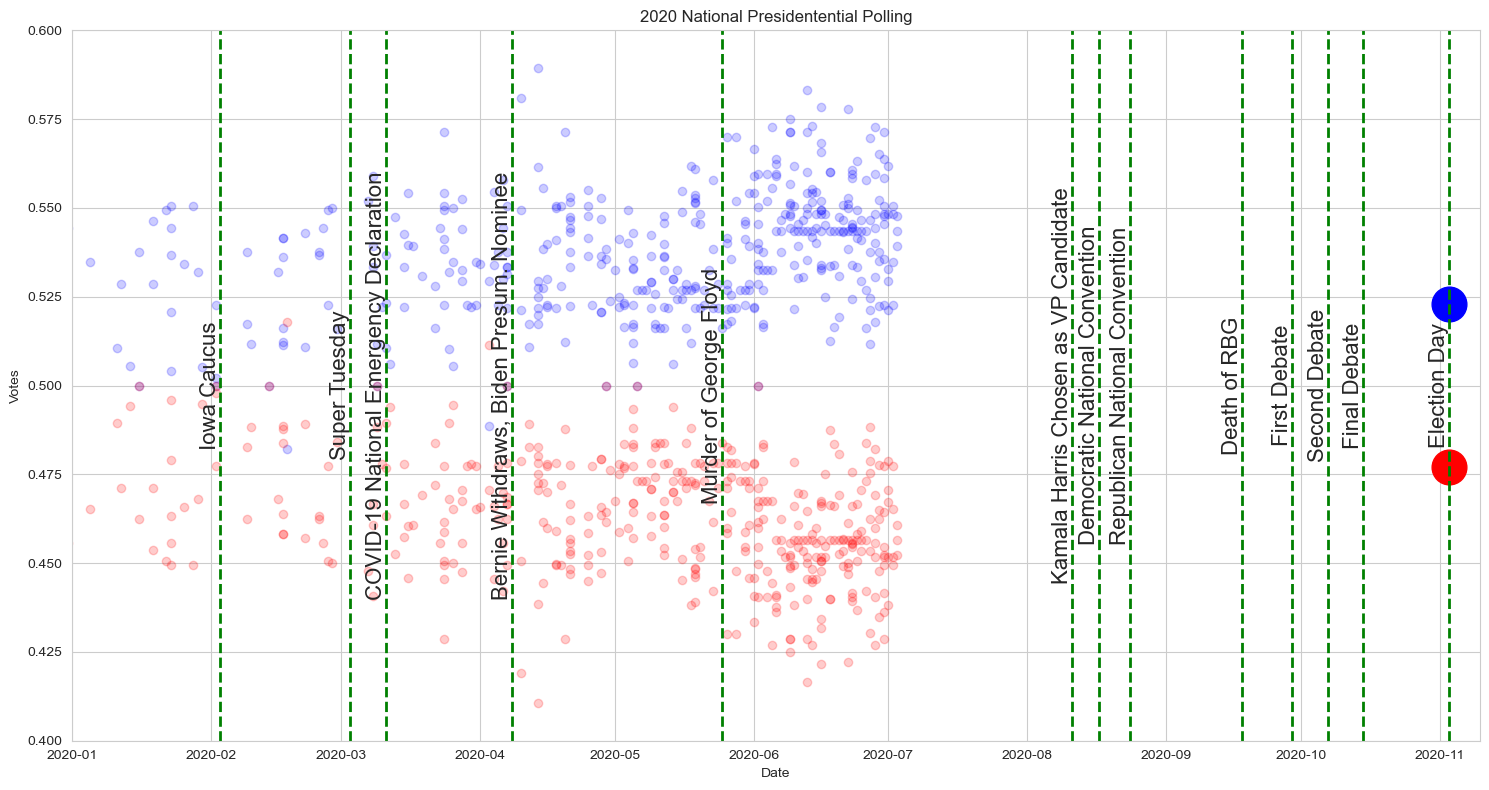

In [12]:
dem_votes = df_2way.query("state == 'US'")["DEM"].values
gop_votes = df_2way.query("state == 'US'")["GOP"].values

dates = df_2way.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.2, color='red', label="Trump")

# Set limits and labels
ax.set_ylim(0.4, 0.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2020 National Presidentential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 2, 3), 'Iowa Caucus'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

# Add large blue dot at the final actual national popular vote for Biden
ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)

# Add large red dot at the final actual national popular vote for Trump
ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Daily standard deviation in polls')

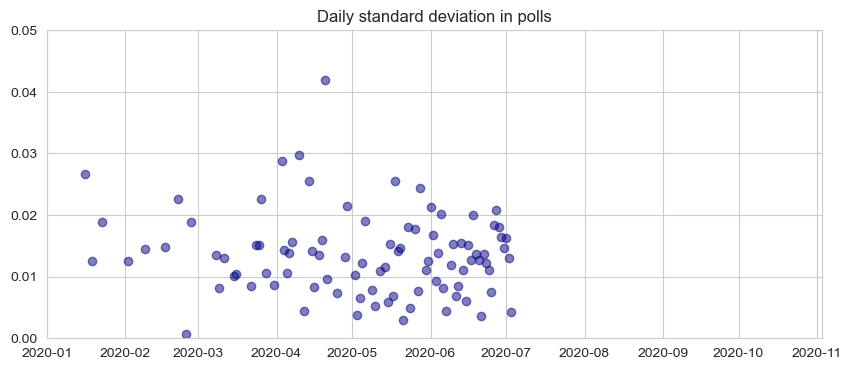

In [13]:
rolling_std = (
    df_2way.query("state == 'US'")[["date", "DEM", "GOP"]]
    .reset_index()
    .groupby(["date"])
    .std()
    .reset_index()[["date", "DEM", "GOP"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.DEM.values,
    "o",
    color = 'navy',
    alpha=0.5,
)

ax.set_ylim(0, .05)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))
ax.set_title("Daily standard deviation in polls")

We can see here that polling methodology is irrelevant, they all perform about the same.

In [14]:
df.query("state == 'US'").query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'IVR/Online Panel', 'IVR/Text', 'Live Phone/Online Panel', 'Text-to-Web/Online Ad']")[['methodology','DEM','GOP']].groupby("methodology").mean()

,DEM,GOP
methodology,,
IVR/Online Panel,0.525397,0.474603
IVR/Text,0.549756,0.450244
Live Phone,0.540653,0.459347
Live Phone/Online Panel,0.518072,0.481928
Online Panel,0.536772,0.463228
Probability Panel,0.537980,0.462020
Text-to-Web/Online Ad,0.529919,0.470081


We can see that Trump fairly consistently out-performs on App Panel polls.

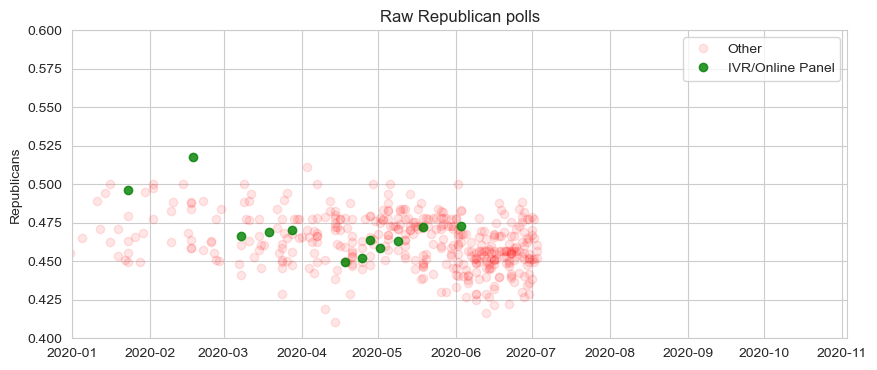

In [15]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "IVR/Online Panel"]
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "IVR/Online Panel"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.1, color = 'red', label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, color = 'green', label="IVR/Online Panel")
ax.set_ylim(.4, .6)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))
ax.legend()

In [16]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [17]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,type,obs_id,type_bt,margin,GOP_mean,DEM_mean,margin_mean,diff_GOP,diff_DEM,diff_margin
0,2020-07-03,66994,125129,383,PPP,IVR/Text,ME,v,971.0,2020,...,2way,0,1,0.12,0.48,0.52,0.04,-0.04,0.04,0.07
1,2020-07-03,67745,126824,1189,Morning Consult,Online Panel,US,lv,11040.0,2020,...,2way,1,1,0.09,0.48,0.52,0.04,-0.02,0.02,0.04
2,2020-07-03,70822,132476,1193,SurveyMonkey,Online Panel,US,rv,16984.0,2020,...,2way,2,1,0.10,0.48,0.52,0.04,-0.03,0.03,0.05
3,2020-07-03,70822,132601,1193,SurveyMonkey,Online Panel,US,lv,17113.0,2020,...,2way,3,1,0.08,0.48,0.52,0.04,-0.02,0.02,0.04
4,2020-07-03,68400,128086,1189,Morning Consult,Online Panel,WI,lv,749.0,2020,...,2way,4,1,0.06,0.48,0.52,0.04,-0.01,0.01,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,2019-11-09,62621,113027,329,Muhlenberg,Live Phone,PA,rv,390.0,2020,...,2way,976,1,0.09,0.47,0.53,0.06,-0.02,0.02,0.03
977,2019-11-08,62590,112864,1189,Morning Consult,Online Panel,US,rv,1131.0,2020,...,2way,977,1,0.05,0.47,0.53,0.06,0.01,-0.01,-0.01
978,2019-11-08,62608,112922,847,U. Georgia SPIA,Live Phone,GA,rv,962.0,2020,...,2way,978,1,0.09,0.47,0.53,0.06,-0.02,0.02,0.03
979,2019-11-05,62570,121443,568,YouGov,Online Panel,US,rv,1069.0,2020,...,2way,979,1,0.06,0.47,0.53,0.06,0.00,-0.00,-0.00


In [18]:
df.groupby('type')[['margin']].mean()

,margin
type,
2way,0.053973


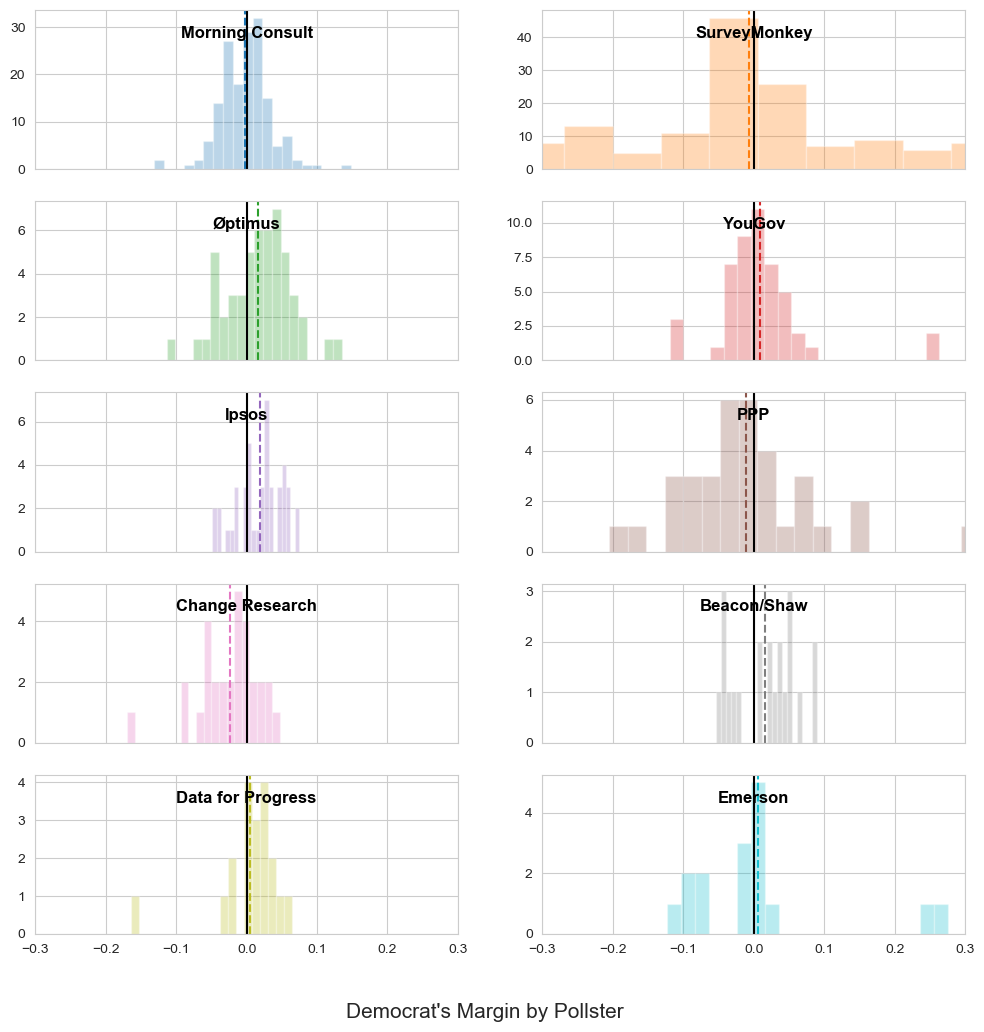

In [19]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.3, .3)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


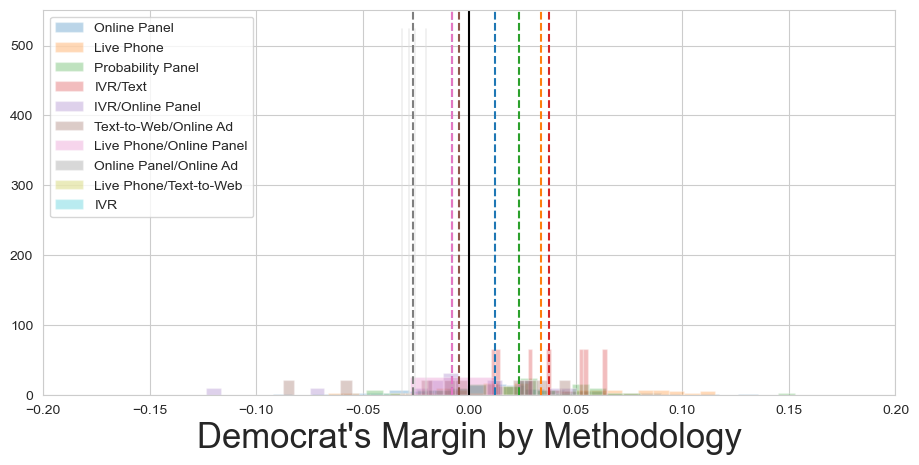

In [20]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25, density=True)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-.2, .2)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [21]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id, day = df.set_index(
    ["day"]
).index.factorize(sort=True)
day = np.concatenate([day, np.arange(max(day)+1, 1)])

party_id, party = [0,1], ['DEM','GOP']

week = np.arange(min(week), 1)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [22]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_state_multi = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")
    dem_day_effect = pm.GaussianRandomWalk("dem_day_effect", sigma=dem_sigma, init_dist=pm.Normal.dist(mu=-0.025, sigma=0.1), dims="day")

    dem_polling = pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    )

    dem_vote = pm.Binomial(
        "dem_vote",
        p=dem_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['DEM'],
        dims="observation",
    )

    polling_error = pm.Normal("polling_error", 0, 2)

    # Sampling
    idata = pm.sample(draws=1000, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, dem_day_effect, polling_error]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 1127 seconds.
Chain 9 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


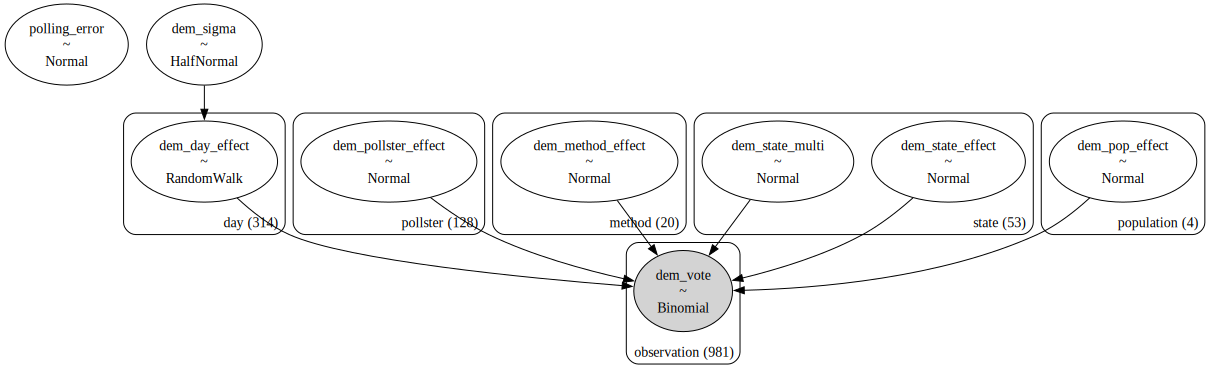

In [23]:
pm.model_to_graphviz(twoway)

In [24]:
states = df['state'].unique()
parties = ['dem','gop', 'margin']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [82]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

for d in tqdm(day):
#for d in [0]:
    
    for state in states:
        
        for party in ['dem']:
            df_results[f"{state}_{party}"] = (inv_logit(
                (idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
                 idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marquette Law School")
                )/2 +
                (idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
                 idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2) +
                 idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone/Online Panel', drop=True).mean(axis=2)
                )/3 +
                idata.posterior[f"{party}_pop_effect"].sel(population="rv") +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}") +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}") *
                idata.posterior[f"{party}_day_effect"].sel(day=d)
              ) + idata.posterior[f"polling_error"]/100).values.ravel()
                
        df_results[f"{state}_gop"] = 1 - df_results[f"{state}_dem"]
        df_results[f"{state}_margin"] = df_results[f"{state}_dem"] - df_results[f"{state}_gop"]

    df_day_mean.loc[d] = df_results.mean()
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 314/314 [02:28<00:00,  2.11it/s]


In [83]:
df_results

,ME_dem,ME_gop,ME_margin,US_dem,US_gop,US_margin,WI_dem,WI_gop,WI_margin,GA_dem,...,AR_margin,AL_dem,AL_gop,AL_margin,AK_dem,AK_gop,AK_margin,NE-2_dem,NE-2_gop,NE-2_margin
0,0.605435,0.394565,0.210869,0.617633,0.382367,0.235267,0.569210,0.430790,0.138420,0.563805,...,0.003815,0.459566,0.540434,-0.080868,0.548964,0.451036,0.097928,0.593025,0.406975,0.186049
1,0.622272,0.377728,0.244544,0.637542,0.362458,0.275085,0.623427,0.376573,0.246855,0.603819,...,0.016705,0.481275,0.518725,-0.037450,0.575952,0.424048,0.151905,0.650213,0.349787,0.300426
2,0.615941,0.384059,0.231882,0.637571,0.362429,0.275143,0.618214,0.381786,0.236428,0.590673,...,-0.051477,0.485727,0.514273,-0.028545,0.552660,0.447340,0.105321,0.669172,0.330828,0.338344
3,0.617117,0.382883,0.234234,0.633092,0.366908,0.266183,0.609740,0.390260,0.219480,0.620980,...,0.047191,0.463670,0.536330,-0.072660,0.565584,0.434416,0.131168,0.640352,0.359648,0.280705
4,0.577269,0.422731,0.154538,0.626691,0.373309,0.253382,0.600227,0.399773,0.200453,0.587586,...,0.013024,0.466389,0.533611,-0.067221,0.577985,0.422015,0.155969,0.579578,0.420422,0.159155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.476705,0.523295,-0.046591,0.495443,0.504557,-0.009114,0.487650,0.512350,-0.024701,0.473918,...,-0.249007,0.362782,0.637218,-0.274437,0.457737,0.542263,-0.084526,0.553463,0.446537,0.106926
9996,0.573657,0.426343,0.147314,0.548573,0.451427,0.097146,0.544242,0.455758,0.088484,0.519023,...,-0.027065,0.434671,0.565329,-0.130659,0.468696,0.531304,-0.062607,0.459681,0.540319,-0.080639
9997,0.513322,0.486678,0.026644,0.498271,0.501729,-0.003458,0.498919,0.501081,-0.002163,0.478479,...,-0.308814,0.376420,0.623580,-0.247159,0.497289,0.502711,-0.005423,0.493016,0.506984,-0.013969
9998,0.581617,0.418383,0.163233,0.558399,0.441601,0.116798,0.547504,0.452496,0.095007,0.529986,...,-0.103306,0.424152,0.575848,-0.151695,0.510724,0.489276,0.021448,0.587151,0.412849,0.174302


In [84]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2020-11-03')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True)
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True)
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True)
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True)
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True)

In [85]:
df_day_mean = df_day_mean.reset_index().set_index('date')
df_day_03 = df_day_03.reset_index().set_index('date')
df_day_25 = df_day_25.reset_index().set_index('date')
df_day_75 = df_day_75.reset_index().set_index('date')
df_day_97 = df_day_97.reset_index().set_index('date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_46012/3479573353.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_46012/3479573353.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

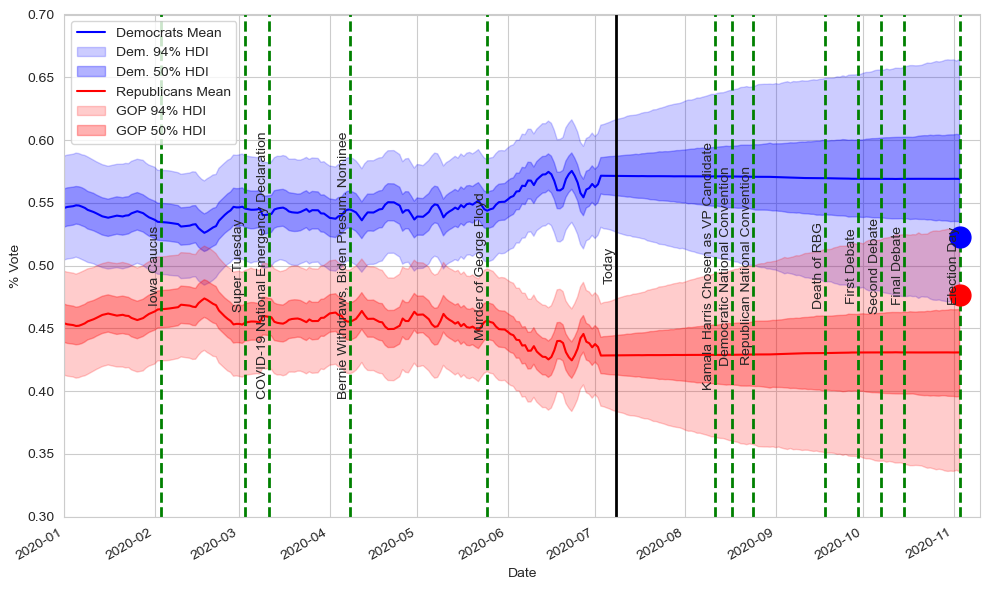

In [86]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

dem_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=0.1, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=0.1, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(0.3,0.7)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 10))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 2, 3), 'Iowa Caucus'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 7, 8), color='black', linestyle='-', linewidth=2)
plt.text(dt.datetime(2020, 7, 8), 0.5, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=15, color='blue', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=15, color='red', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

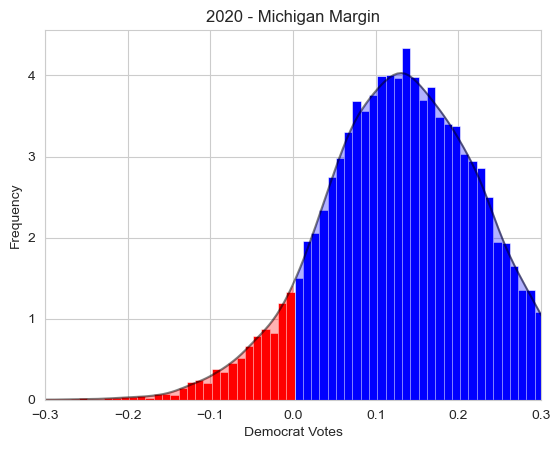

In [71]:
# TX, CA, MN, MI, FL, GA

graph_state = 'MI'

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_results[f"{graph_state}_margin"], binwidth=.01, kde=False, stat="density")

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() + 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 0:
        patch.set_facecolor('red')
    elif x > 0:
        patch.set_facecolor('blue')
    elif x == 0:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('green')

# Plot KDE
kde_ax = sns.kdeplot(df_results[f"{graph_state}_margin"], color='black', alpha = 0.5, ax=ax)

# Fill area above 270 with red color
kde_x, kde_y = kde_ax.get_lines()[0].get_data()
kde_ax.fill_between(kde_x, kde_y, where=(kde_x >= 0), color='blue', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x <= 0), color='red', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x == 0), color='lime', alpha=1)


# Adding titles and labels
plt.title('2020 - Michigan Margin')
plt.xlabel('Democrat Votes')
plt.xlim(-.3, .3)
plt.ylabel('Frequency')

events = [
    #(13, 'Mondale 1984'),
    #(49, 'Carter 1980'),
    #(486, 'Johnson 1964')
]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    plt.text(date, .05, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

# Display the plot
plt.savefig('2way_enight_mi.png')

In [72]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [73]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

19    ME-1
20    ME-2
30    NE-1
32    NE-3
Name: state_code, dtype: object

In [74]:
#df_winner[['AR', 'ID', 'KS', 'KY', 'ME-2', 'MS', 'NE-1', 'NE-3', 'ND', 'WY']] = 'gop'
#df_winner[['CT', 'DE', 'IL','ME-1', 'DC']] = 'dem'

df_winner[['NE-1','ME-2','NE-3']] = 'gop'
df_winner[['ME-1']] = 'dem'

#df_winner[['NE-3']] = 'gop'

state_order = df_state['state_code'].to_list

In [75]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_46012/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_46012/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [76]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', 'electoral_2020']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', 'electoral_2020']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)

In [77]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(88.82, 0.12, 11.06)

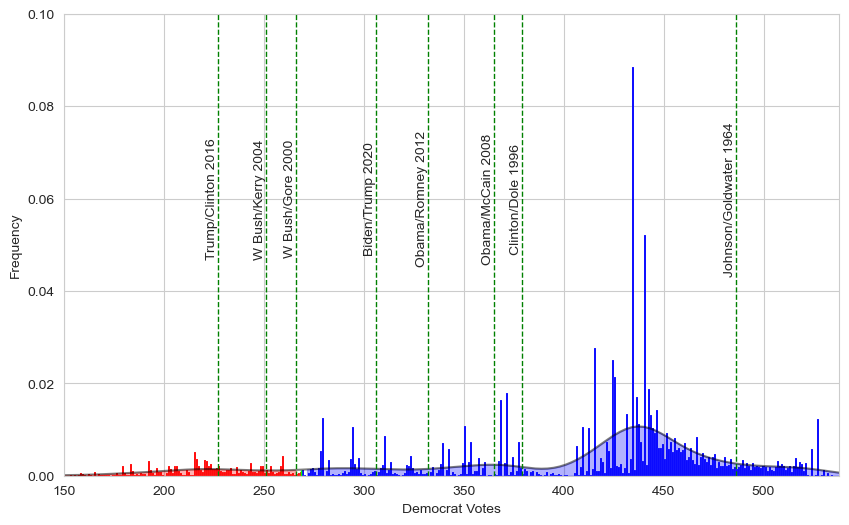

In [78]:
# Plotting the histograms
plt.figure(figsize=(10, 6))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_ec['dem'], binwidth=1, kde=False, stat="density")

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() + 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('green')

# Plot KDE
kde_ax = sns.kdeplot(df_ec['dem'], color='black', alpha = 0.5, ax=ax)

# Fill area above 270 with red color
kde_x, kde_y = kde_ax.get_lines()[0].get_data()
kde_ax.fill_between(kde_x, kde_y, where=(kde_x >= 270), color='blue', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x <= 268), color='red', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x > 268) & (kde_x < 270), color='lime', alpha=1)


# Adding titles and labels
#plt.title('2024 Election Night - Electoral College Results')
plt.xlabel('Democrat Votes')
plt.xlim(150, 538)
plt.ylim(0, .1)
plt.ylabel('Frequency')

events = [
    #(13, 'Mondale 1984'),
    #(49, 'Carter 1980'),
    #(111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    (486, 'Johnson/Goldwater 1964')
]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    plt.text(date, .06, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

# Display the plot
plt.savefig('2way_enight_ec.png')

In [79]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [80]:
df_win_pct.sort_values('dem')

,dem,gop
NE-3,0.0000,1.0000
NE-1,0.0000,1.0000
ME-2,0.0000,1.0000
WV,0.0009,0.9991
WY,0.0019,0.9981
ND,0.0450,0.9550
KY,0.0635,0.9365
AL,0.0667,0.9333
OK,0.0751,0.9249
TN,0.0787,0.9213
